In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
X, y = skds.fetch_openml("cardiotocography", return_X_y=True, version=2)
y[y=='1'] = 1
y[y=='2'] = 0
y[y=='3'] = 0

In [8]:
X = StandardScaler().fit_transform(X)


In [10]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(471, 35)
(1655, 35)


In [11]:
indices=np.arange(235)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:235]
x_train=np.concatenate((np.array(x_neg[0:235])[indices],x_pos)).reshape(-1,35)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [12]:
x_test = x_neg[235:471].reshape(-1,35)
y_test = y_neg[235:471].reshape(-1,1)

# Projection model

In [13]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [14]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [15]:
num_of_iterations = 20 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(1655, 35)
Size: 10 Bits - FPR: 0.953390 - Time Taken to create filter(sec): 0.448403 



Size: 20 Bits - FPR: 0.775424 - Time Taken to create filter(sec): 0.397285 



Size: 30 Bits - FPR: 0.877119 - Time Taken to create filter(sec): 0.403805 



Size: 40 Bits - FPR: 0.817797 - Time Taken to create filter(sec): 0.407437 



Size: 50 Bits - FPR: 0.779661 - Time Taken to create filter(sec): 0.502101 



Size: 60 Bits - FPR: 0.851695 - Time Taken to create filter(sec): 0.533030 



Size: 70 Bits - FPR: 0.830508 - Time Taken to create filter(sec): 0.484187 



Size: 80 Bits - FPR: 0.796610 - Time Taken to create filter(sec): 0.520544 



Size: 90 Bits - FPR: 0.796610 - Time Taken to create filter(sec): 0.515833 



Size: 100 Bits - FPR: 0.737288 - Time Taken to create filter(sec): 0.441925 



Size: 110 Bits - FPR: 0.741525 - Time Taken to create filter(sec): 0.453152 



Size: 120 Bits - FPR: 0.800847 - Time Taken to create filter(sec): 0.436087 



Size: 

Size: 1030 Bits - FPR: 0.457627 - Time Taken to create filter(sec): 0.482084 



Size: 1040 Bits - FPR: 0.457627 - Time Taken to create filter(sec): 0.456369 



Size: 1050 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.396309 



Size: 1060 Bits - FPR: 0.563559 - Time Taken to create filter(sec): 0.393501 



Size: 1070 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.414680 



Size: 1080 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.398651 



Size: 1090 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.395318 



Size: 1100 Bits - FPR: 0.415254 - Time Taken to create filter(sec): 0.402248 



Size: 1110 Bits - FPR: 0.495763 - Time Taken to create filter(sec): 0.397581 



Size: 1120 Bits - FPR: 0.516949 - Time Taken to create filter(sec): 0.413985 



Size: 1130 Bits - FPR: 0.474576 - Time Taken to create filter(sec): 0.411591 



Size: 1140 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 0.394488 



Size: 1150 Bits - FPR: 0.406

Size: 2050 Bits - FPR: 0.203390 - Time Taken to create filter(sec): 0.410921 



Size: 2060 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.401069 



Size: 2070 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.422813 



Size: 2080 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.450616 



Size: 2090 Bits - FPR: 0.292373 - Time Taken to create filter(sec): 0.435251 



Size: 2100 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.402950 



Size: 2110 Bits - FPR: 0.266949 - Time Taken to create filter(sec): 0.425184 



Size: 2120 Bits - FPR: 0.228814 - Time Taken to create filter(sec): 0.416137 



Size: 2130 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.418409 



Size: 2140 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.507823 



Size: 2150 Bits - FPR: 0.224576 - Time Taken to create filter(sec): 0.403800 



Size: 2160 Bits - FPR: 0.203390 - Time Taken to create filter(sec): 0.397278 



Size: 2170 Bits - FPR: 0.330

Size: 60 Bits - FPR: 0.817797 - Time Taken to create filter(sec): 0.396798 



Size: 70 Bits - FPR: 0.822034 - Time Taken to create filter(sec): 0.395333 



Size: 80 Bits - FPR: 0.817797 - Time Taken to create filter(sec): 0.398960 



Size: 90 Bits - FPR: 0.860169 - Time Taken to create filter(sec): 0.400412 



Size: 100 Bits - FPR: 0.750000 - Time Taken to create filter(sec): 0.436956 



Size: 110 Bits - FPR: 0.796610 - Time Taken to create filter(sec): 0.423365 



Size: 120 Bits - FPR: 0.822034 - Time Taken to create filter(sec): 0.421196 



Size: 130 Bits - FPR: 0.669492 - Time Taken to create filter(sec): 0.410184 



Size: 140 Bits - FPR: 0.694915 - Time Taken to create filter(sec): 0.395441 



Size: 150 Bits - FPR: 0.809322 - Time Taken to create filter(sec): 0.395268 



Size: 160 Bits - FPR: 0.758475 - Time Taken to create filter(sec): 0.391556 



Size: 170 Bits - FPR: 0.745763 - Time Taken to create filter(sec): 0.392160 



Size: 180 Bits - FPR: 0.813559 - Time Taken 

Size: 1090 Bits - FPR: 0.360169 - Time Taken to create filter(sec): 0.400797 



Size: 1100 Bits - FPR: 0.521186 - Time Taken to create filter(sec): 0.390345 



Size: 1110 Bits - FPR: 0.330508 - Time Taken to create filter(sec): 0.389307 



Size: 1120 Bits - FPR: 0.423729 - Time Taken to create filter(sec): 0.395079 



Size: 1130 Bits - FPR: 0.478814 - Time Taken to create filter(sec): 0.388427 



Size: 1140 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.392421 



Size: 1150 Bits - FPR: 0.309322 - Time Taken to create filter(sec): 0.390012 



Size: 1160 Bits - FPR: 0.461864 - Time Taken to create filter(sec): 0.397074 



Size: 1170 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.393574 



Size: 1180 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.392864 



Size: 1190 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.395700 



Size: 1200 Bits - FPR: 0.394068 - Time Taken to create filter(sec): 0.438347 



Size: 1210 Bits - FPR: 0.449

Size: 2110 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.395923 



Size: 2120 Bits - FPR: 0.377119 - Time Taken to create filter(sec): 0.392187 



Size: 2130 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.388932 



Size: 2140 Bits - FPR: 0.398305 - Time Taken to create filter(sec): 0.390615 



Size: 2150 Bits - FPR: 0.398305 - Time Taken to create filter(sec): 0.390052 



Size: 2160 Bits - FPR: 0.211864 - Time Taken to create filter(sec): 0.389290 



Size: 2170 Bits - FPR: 0.300847 - Time Taken to create filter(sec): 0.407769 



Size: 2180 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.394165 



Size: 2190 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.390867 



Size: 2200 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.389808 



Size: 2210 Bits - FPR: 0.330508 - Time Taken to create filter(sec): 0.389487 



Size: 2220 Bits - FPR: 0.292373 - Time Taken to create filter(sec): 0.390570 



Size: 2230 Bits - FPR: 0.258

Size: 120 Bits - FPR: 0.771186 - Time Taken to create filter(sec): 0.394681 



Size: 130 Bits - FPR: 0.779661 - Time Taken to create filter(sec): 0.390755 



Size: 140 Bits - FPR: 0.800847 - Time Taken to create filter(sec): 0.393349 



Size: 150 Bits - FPR: 0.796610 - Time Taken to create filter(sec): 0.395035 



Size: 160 Bits - FPR: 0.728814 - Time Taken to create filter(sec): 0.394042 



Size: 170 Bits - FPR: 0.733051 - Time Taken to create filter(sec): 0.394720 



Size: 180 Bits - FPR: 0.792373 - Time Taken to create filter(sec): 0.391899 



Size: 190 Bits - FPR: 0.809322 - Time Taken to create filter(sec): 0.396646 



Size: 200 Bits - FPR: 0.847458 - Time Taken to create filter(sec): 0.392067 



Size: 210 Bits - FPR: 0.652542 - Time Taken to create filter(sec): 0.420727 



Size: 220 Bits - FPR: 0.834746 - Time Taken to create filter(sec): 0.445169 



Size: 230 Bits - FPR: 0.783898 - Time Taken to create filter(sec): 0.396428 



Size: 240 Bits - FPR: 0.686441 - Time Ta

Size: 1150 Bits - FPR: 0.483051 - Time Taken to create filter(sec): 0.393307 



Size: 1160 Bits - FPR: 0.411017 - Time Taken to create filter(sec): 0.390164 



Size: 1170 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.428575 



Size: 1180 Bits - FPR: 0.385593 - Time Taken to create filter(sec): 0.394337 



Size: 1190 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.390815 



Size: 1200 Bits - FPR: 0.525424 - Time Taken to create filter(sec): 0.405130 



Size: 1210 Bits - FPR: 0.546610 - Time Taken to create filter(sec): 0.935637 



Size: 1220 Bits - FPR: 0.432203 - Time Taken to create filter(sec): 0.722934 



Size: 1230 Bits - FPR: 0.415254 - Time Taken to create filter(sec): 0.924249 



Size: 1240 Bits - FPR: 0.491525 - Time Taken to create filter(sec): 0.727203 



Size: 1250 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.488350 



Size: 1260 Bits - FPR: 0.504237 - Time Taken to create filter(sec): 0.766159 



Size: 1270 Bits - FPR: 0.402

Size: 2170 Bits - FPR: 0.334746 - Time Taken to create filter(sec): 0.547611 



Size: 2180 Bits - FPR: 0.241525 - Time Taken to create filter(sec): 0.578899 



Size: 2190 Bits - FPR: 0.343220 - Time Taken to create filter(sec): 0.591127 



Size: 2200 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.389834 



Size: 2210 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.579215 



Size: 2220 Bits - FPR: 0.385593 - Time Taken to create filter(sec): 0.427080 



Size: 2230 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.515187 



Size: 2240 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.534010 



Size: 2250 Bits - FPR: 0.186441 - Time Taken to create filter(sec): 0.495107 



Size: 2260 Bits - FPR: 0.288136 - Time Taken to create filter(sec): 0.395553 



Size: 2270 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.394067 



Size: 2280 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.401839 



Size: 2290 Bits - FPR: 0.330

Size: 180 Bits - FPR: 0.826271 - Time Taken to create filter(sec): 0.394388 



Size: 190 Bits - FPR: 0.720339 - Time Taken to create filter(sec): 0.422126 



Size: 200 Bits - FPR: 0.716102 - Time Taken to create filter(sec): 0.408374 



Size: 210 Bits - FPR: 0.758475 - Time Taken to create filter(sec): 0.611884 



Size: 220 Bits - FPR: 0.766949 - Time Taken to create filter(sec): 0.729821 



Size: 230 Bits - FPR: 0.758475 - Time Taken to create filter(sec): 0.681404 



Size: 240 Bits - FPR: 0.720339 - Time Taken to create filter(sec): 0.595116 



Size: 250 Bits - FPR: 0.720339 - Time Taken to create filter(sec): 0.429048 



Size: 260 Bits - FPR: 0.699153 - Time Taken to create filter(sec): 0.409614 



Size: 270 Bits - FPR: 0.788136 - Time Taken to create filter(sec): 0.507150 



Size: 280 Bits - FPR: 0.737288 - Time Taken to create filter(sec): 0.686442 



Size: 290 Bits - FPR: 0.690678 - Time Taken to create filter(sec): 0.556699 



Size: 300 Bits - FPR: 0.711864 - Time Ta

Size: 1210 Bits - FPR: 0.436441 - Time Taken to create filter(sec): 0.441978 



Size: 1220 Bits - FPR: 0.389831 - Time Taken to create filter(sec): 0.591329 



Size: 1230 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.491271 



Size: 1240 Bits - FPR: 0.377119 - Time Taken to create filter(sec): 0.459691 



Size: 1250 Bits - FPR: 0.491525 - Time Taken to create filter(sec): 0.502404 



Size: 1260 Bits - FPR: 0.483051 - Time Taken to create filter(sec): 0.548462 



Size: 1270 Bits - FPR: 0.389831 - Time Taken to create filter(sec): 0.481823 



Size: 1280 Bits - FPR: 0.470339 - Time Taken to create filter(sec): 0.434771 



Size: 1290 Bits - FPR: 0.457627 - Time Taken to create filter(sec): 0.681471 



Size: 1300 Bits - FPR: 0.487288 - Time Taken to create filter(sec): 1.177779 



Size: 1310 Bits - FPR: 0.529661 - Time Taken to create filter(sec): 0.919305 



Size: 1320 Bits - FPR: 0.516949 - Time Taken to create filter(sec): 0.813700 



Size: 1330 Bits - FPR: 0.521

Size: 2230 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.545662 



Size: 2240 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.394967 



Size: 2250 Bits - FPR: 0.182203 - Time Taken to create filter(sec): 0.435309 



Size: 2260 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.391062 



Size: 2270 Bits - FPR: 0.211864 - Time Taken to create filter(sec): 0.456953 



Size: 2280 Bits - FPR: 0.279661 - Time Taken to create filter(sec): 0.444767 



Size: 2290 Bits - FPR: 0.360169 - Time Taken to create filter(sec): 0.465354 



Size: 2300 Bits - FPR: 0.334746 - Time Taken to create filter(sec): 0.407560 



Size: 2310 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.412471 



Size: 2320 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.387790 



Size: 2330 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.418053 



Size: 2340 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.406196 



Size: 2350 Bits - FPR: 0.220

Size: 250 Bits - FPR: 0.682203 - Time Taken to create filter(sec): 0.397502 



Size: 260 Bits - FPR: 0.724576 - Time Taken to create filter(sec): 0.445866 



Size: 270 Bits - FPR: 0.597458 - Time Taken to create filter(sec): 0.480333 



Size: 280 Bits - FPR: 0.716102 - Time Taken to create filter(sec): 0.603447 



Size: 290 Bits - FPR: 0.796610 - Time Taken to create filter(sec): 0.517599 



Size: 300 Bits - FPR: 0.563559 - Time Taken to create filter(sec): 0.580223 



Size: 310 Bits - FPR: 0.618644 - Time Taken to create filter(sec): 0.432494 



Size: 320 Bits - FPR: 0.618644 - Time Taken to create filter(sec): 0.485664 



Size: 330 Bits - FPR: 0.567797 - Time Taken to create filter(sec): 0.590963 



Size: 340 Bits - FPR: 0.512712 - Time Taken to create filter(sec): 0.580101 



Size: 350 Bits - FPR: 0.724576 - Time Taken to create filter(sec): 0.422812 



Size: 360 Bits - FPR: 0.745763 - Time Taken to create filter(sec): 0.423623 



Size: 370 Bits - FPR: 0.783898 - Time Ta

Size: 1280 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.717001 



Size: 1290 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.717031 



Size: 1300 Bits - FPR: 0.550847 - Time Taken to create filter(sec): 0.716723 



Size: 1310 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.723189 



Size: 1320 Bits - FPR: 0.377119 - Time Taken to create filter(sec): 0.726110 



Size: 1330 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.703350 



Size: 1340 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.709956 



Size: 1350 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.710123 



Size: 1360 Bits - FPR: 0.500000 - Time Taken to create filter(sec): 0.716807 



Size: 1370 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.715762 



Size: 1380 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.728048 



Size: 1390 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.716185 



Size: 1400 Bits - FPR: 0.495

Size: 2300 Bits - FPR: 0.279661 - Time Taken to create filter(sec): 0.713915 



Size: 2310 Bits - FPR: 0.241525 - Time Taken to create filter(sec): 0.714608 



Size: 2320 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.720079 



Size: 2330 Bits - FPR: 0.241525 - Time Taken to create filter(sec): 0.726968 



Size: 2340 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.706045 



Size: 2350 Bits - FPR: 0.398305 - Time Taken to create filter(sec): 0.717805 



Size: 2360 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.734667 



Size: 2370 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.724867 



Size: 2380 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.713375 



Size: 2390 Bits - FPR: 0.199153 - Time Taken to create filter(sec): 0.703778 



Size: 2400 Bits - FPR: 0.266949 - Time Taken to create filter(sec): 0.714015 



Size: 2410 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.719998 



Size: 2420 Bits - FPR: 0.313

Size: 320 Bits - FPR: 0.699153 - Time Taken to create filter(sec): 0.699667 



Size: 330 Bits - FPR: 0.686441 - Time Taken to create filter(sec): 0.708875 



Size: 340 Bits - FPR: 0.775424 - Time Taken to create filter(sec): 0.705301 



Size: 350 Bits - FPR: 0.631356 - Time Taken to create filter(sec): 0.702784 



Size: 360 Bits - FPR: 0.669492 - Time Taken to create filter(sec): 0.711902 



Size: 370 Bits - FPR: 0.690678 - Time Taken to create filter(sec): 0.701464 



Size: 380 Bits - FPR: 0.762712 - Time Taken to create filter(sec): 0.710189 



Size: 390 Bits - FPR: 0.597458 - Time Taken to create filter(sec): 0.738847 



Size: 400 Bits - FPR: 0.699153 - Time Taken to create filter(sec): 0.738562 



Size: 410 Bits - FPR: 0.648305 - Time Taken to create filter(sec): 0.738464 



Size: 420 Bits - FPR: 0.661017 - Time Taken to create filter(sec): 0.720151 



Size: 430 Bits - FPR: 0.550847 - Time Taken to create filter(sec): 0.713629 



Size: 440 Bits - FPR: 0.622881 - Time Ta

Size: 1340 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.714997 



Size: 1350 Bits - FPR: 0.411017 - Time Taken to create filter(sec): 0.721585 



Size: 1360 Bits - FPR: 0.398305 - Time Taken to create filter(sec): 0.715591 



Size: 1370 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.714110 



Size: 1380 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.710979 



Size: 1390 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.718124 



Size: 1400 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.719397 



Size: 1410 Bits - FPR: 0.300847 - Time Taken to create filter(sec): 0.713325 



Size: 1420 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.723724 



Size: 1430 Bits - FPR: 0.461864 - Time Taken to create filter(sec): 0.702995 



Size: 1440 Bits - FPR: 0.466102 - Time Taken to create filter(sec): 0.718394 



Size: 1450 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 0.715887 



Size: 1460 Bits - FPR: 0.487

Size: 2360 Bits - FPR: 0.360169 - Time Taken to create filter(sec): 0.706786 



Size: 2370 Bits - FPR: 0.220339 - Time Taken to create filter(sec): 0.722807 



Size: 2380 Bits - FPR: 0.360169 - Time Taken to create filter(sec): 0.719658 



Size: 2390 Bits - FPR: 0.377119 - Time Taken to create filter(sec): 0.712407 



Size: 2400 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.703526 



Size: 2410 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.722816 



Size: 2420 Bits - FPR: 0.182203 - Time Taken to create filter(sec): 0.702406 



Size: 2430 Bits - FPR: 0.309322 - Time Taken to create filter(sec): 0.773231 



Size: 2440 Bits - FPR: 0.233051 - Time Taken to create filter(sec): 0.723576 



Size: 2450 Bits - FPR: 0.360169 - Time Taken to create filter(sec): 0.708431 



Size: 2460 Bits - FPR: 0.326271 - Time Taken to create filter(sec): 0.700666 



Size: 2470 Bits - FPR: 0.220339 - Time Taken to create filter(sec): 0.711463 



Size: 2480 Bits - FPR: 0.258

Size: 380 Bits - FPR: 0.593220 - Time Taken to create filter(sec): 0.719914 



Size: 390 Bits - FPR: 0.673729 - Time Taken to create filter(sec): 0.708301 



Size: 400 Bits - FPR: 0.504237 - Time Taken to create filter(sec): 0.711180 



Size: 410 Bits - FPR: 0.771186 - Time Taken to create filter(sec): 0.722221 



Size: 420 Bits - FPR: 0.478814 - Time Taken to create filter(sec): 0.715288 



Size: 430 Bits - FPR: 0.665254 - Time Taken to create filter(sec): 0.711669 



Size: 440 Bits - FPR: 0.635593 - Time Taken to create filter(sec): 0.715811 



Size: 450 Bits - FPR: 0.648305 - Time Taken to create filter(sec): 0.716704 



Size: 460 Bits - FPR: 0.652542 - Time Taken to create filter(sec): 0.713192 



Size: 470 Bits - FPR: 0.601695 - Time Taken to create filter(sec): 0.712374 



Size: 480 Bits - FPR: 0.686441 - Time Taken to create filter(sec): 0.738919 



Size: 490 Bits - FPR: 0.572034 - Time Taken to create filter(sec): 0.724729 



Size: 500 Bits - FPR: 0.673729 - Time Ta

Size: 1400 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.744005 



Size: 1410 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.707004 



Size: 1420 Bits - FPR: 0.233051 - Time Taken to create filter(sec): 0.722219 



Size: 1430 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.718836 



Size: 1440 Bits - FPR: 0.436441 - Time Taken to create filter(sec): 0.714761 



Size: 1450 Bits - FPR: 0.343220 - Time Taken to create filter(sec): 0.715524 



Size: 1460 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.711759 



Size: 1470 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.708537 



Size: 1480 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.714617 



Size: 1490 Bits - FPR: 0.402542 - Time Taken to create filter(sec): 0.708773 



Size: 1500 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.724388 



Size: 1510 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.715190 



Size: 1520 Bits - FPR: 0.385

Size: 2420 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.708780 



Size: 2430 Bits - FPR: 0.237288 - Time Taken to create filter(sec): 0.745935 



Size: 2440 Bits - FPR: 0.334746 - Time Taken to create filter(sec): 0.710994 



Size: 2450 Bits - FPR: 0.203390 - Time Taken to create filter(sec): 0.708412 



Size: 2460 Bits - FPR: 0.224576 - Time Taken to create filter(sec): 0.705334 



Size: 2470 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.721213 



Size: 2480 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.709523 



Size: 2490 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.714208 



Size: 2500 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.701599 



Size: 2510 Bits - FPR: 0.300847 - Time Taken to create filter(sec): 0.710274 



Size: 2520 Bits - FPR: 0.199153 - Time Taken to create filter(sec): 0.713493 



Size: 2530 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.711653 



Size: 2540 Bits - FPR: 0.262

Size: 440 Bits - FPR: 0.694915 - Time Taken to create filter(sec): 0.712773 



Size: 450 Bits - FPR: 0.538136 - Time Taken to create filter(sec): 0.725440 



Size: 460 Bits - FPR: 0.639831 - Time Taken to create filter(sec): 0.720958 



Size: 470 Bits - FPR: 0.563559 - Time Taken to create filter(sec): 0.718141 



Size: 480 Bits - FPR: 0.474576 - Time Taken to create filter(sec): 0.716538 



Size: 490 Bits - FPR: 0.644068 - Time Taken to create filter(sec): 0.714171 



Size: 500 Bits - FPR: 0.618644 - Time Taken to create filter(sec): 0.721653 



Size: 510 Bits - FPR: 0.584746 - Time Taken to create filter(sec): 0.719972 



Size: 520 Bits - FPR: 0.597458 - Time Taken to create filter(sec): 0.818548 



Size: 530 Bits - FPR: 0.559322 - Time Taken to create filter(sec): 0.735624 



Size: 540 Bits - FPR: 0.555085 - Time Taken to create filter(sec): 0.728429 



Size: 550 Bits - FPR: 0.466102 - Time Taken to create filter(sec): 0.792115 



Size: 560 Bits - FPR: 0.427966 - Time Ta

Size: 1460 Bits - FPR: 0.423729 - Time Taken to create filter(sec): 0.719025 



Size: 1470 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.713190 



Size: 1480 Bits - FPR: 0.368644 - Time Taken to create filter(sec): 0.719137 



Size: 1490 Bits - FPR: 0.415254 - Time Taken to create filter(sec): 0.715863 



Size: 1500 Bits - FPR: 0.415254 - Time Taken to create filter(sec): 0.711336 



Size: 1510 Bits - FPR: 0.423729 - Time Taken to create filter(sec): 0.707515 



Size: 1520 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.723007 



Size: 1530 Bits - FPR: 0.334746 - Time Taken to create filter(sec): 0.711186 



Size: 1540 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.712059 



Size: 1550 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.705741 



Size: 1560 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.701213 



Size: 1570 Bits - FPR: 0.343220 - Time Taken to create filter(sec): 0.706099 



Size: 1580 Bits - FPR: 0.355

Size: 2480 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.718217 



Size: 2490 Bits - FPR: 0.237288 - Time Taken to create filter(sec): 0.700872 



Size: 2500 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.706323 



Size: 2510 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.744293 



Size: 2520 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.728003 



Size: 2530 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.713504 



Size: 2540 Bits - FPR: 0.440678 - Time Taken to create filter(sec): 0.710106 



Size: 2550 Bits - FPR: 0.288136 - Time Taken to create filter(sec): 0.706738 



Size: 2560 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.711202 



Size: 2570 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.710528 



Size: 2580 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.704202 



Size: 2590 Bits - FPR: 0.279661 - Time Taken to create filter(sec): 0.707267 



Size: 2600 Bits - FPR: 0.283

Size: 500 Bits - FPR: 0.495763 - Time Taken to create filter(sec): 0.830922 



Size: 510 Bits - FPR: 0.639831 - Time Taken to create filter(sec): 1.097724 



Size: 520 Bits - FPR: 0.529661 - Time Taken to create filter(sec): 0.825981 



Size: 530 Bits - FPR: 0.707627 - Time Taken to create filter(sec): 0.986119 



Size: 540 Bits - FPR: 0.665254 - Time Taken to create filter(sec): 0.863648 



Size: 550 Bits - FPR: 0.487288 - Time Taken to create filter(sec): 0.866459 



Size: 560 Bits - FPR: 0.627119 - Time Taken to create filter(sec): 0.830446 



Size: 570 Bits - FPR: 0.644068 - Time Taken to create filter(sec): 0.882242 



Size: 580 Bits - FPR: 0.588983 - Time Taken to create filter(sec): 1.023796 



Size: 590 Bits - FPR: 0.686441 - Time Taken to create filter(sec): 0.723728 



Size: 600 Bits - FPR: 0.601695 - Time Taken to create filter(sec): 0.734953 



Size: 610 Bits - FPR: 0.504237 - Time Taken to create filter(sec): 0.749545 



Size: 620 Bits - FPR: 0.563559 - Time Ta

Size: 1520 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.707780 



Size: 1530 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.711312 



Size: 1540 Bits - FPR: 0.402542 - Time Taken to create filter(sec): 0.703756 



Size: 1550 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.726798 



Size: 1560 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.720583 



Size: 1570 Bits - FPR: 0.457627 - Time Taken to create filter(sec): 0.717833 



Size: 1580 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.726056 



Size: 1590 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 0.721096 



Size: 1600 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 0.712038 



Size: 1610 Bits - FPR: 0.394068 - Time Taken to create filter(sec): 0.713899 



Size: 1620 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.719789 



Size: 1630 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.712253 



Size: 1640 Bits - FPR: 0.364

Size: 2540 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.704658 



Size: 2550 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.715316 



Size: 2560 Bits - FPR: 0.254237 - Time Taken to create filter(sec): 0.705888 



Size: 2570 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.778231 



Size: 2580 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.728658 



Size: 2590 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.718957 



Size: 2600 Bits - FPR: 0.266949 - Time Taken to create filter(sec): 0.709571 



Size: 2610 Bits - FPR: 0.271186 - Time Taken to create filter(sec): 0.711710 



Size: 2620 Bits - FPR: 0.245763 - Time Taken to create filter(sec): 0.706793 



Size: 2630 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.704352 



Size: 2640 Bits - FPR: 0.228814 - Time Taken to create filter(sec): 0.705476 



Size: 2650 Bits - FPR: 0.377119 - Time Taken to create filter(sec): 0.715507 



Size: 2660 Bits - FPR: 0.288

Size: 560 Bits - FPR: 0.584746 - Time Taken to create filter(sec): 0.739112 



Size: 570 Bits - FPR: 0.580508 - Time Taken to create filter(sec): 0.726183 



Size: 580 Bits - FPR: 0.605932 - Time Taken to create filter(sec): 0.729372 



Size: 590 Bits - FPR: 0.563559 - Time Taken to create filter(sec): 0.732614 



Size: 600 Bits - FPR: 0.648305 - Time Taken to create filter(sec): 0.717466 



Size: 610 Bits - FPR: 0.588983 - Time Taken to create filter(sec): 0.727159 



Size: 620 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.716617 



Size: 630 Bits - FPR: 0.682203 - Time Taken to create filter(sec): 0.720727 



Size: 640 Bits - FPR: 0.605932 - Time Taken to create filter(sec): 0.727798 



Size: 650 Bits - FPR: 0.563559 - Time Taken to create filter(sec): 0.718180 



Size: 660 Bits - FPR: 0.652542 - Time Taken to create filter(sec): 0.718296 



Size: 670 Bits - FPR: 0.639831 - Time Taken to create filter(sec): 0.714062 



Size: 680 Bits - FPR: 0.559322 - Time Ta

Size: 1580 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.710955 



Size: 1590 Bits - FPR: 0.389831 - Time Taken to create filter(sec): 0.709273 



Size: 1600 Bits - FPR: 0.334746 - Time Taken to create filter(sec): 0.732221 



Size: 1610 Bits - FPR: 0.330508 - Time Taken to create filter(sec): 0.704246 



Size: 1620 Bits - FPR: 0.377119 - Time Taken to create filter(sec): 0.716159 



Size: 1630 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.710865 



Size: 1640 Bits - FPR: 0.326271 - Time Taken to create filter(sec): 0.722024 



Size: 1650 Bits - FPR: 0.440678 - Time Taken to create filter(sec): 0.713512 



Size: 1660 Bits - FPR: 0.309322 - Time Taken to create filter(sec): 0.712434 



Size: 1670 Bits - FPR: 0.440678 - Time Taken to create filter(sec): 0.713621 



Size: 1680 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.705791 



Size: 1690 Bits - FPR: 0.436441 - Time Taken to create filter(sec): 0.733944 



Size: 1700 Bits - FPR: 0.427

Size: 2600 Bits - FPR: 0.279661 - Time Taken to create filter(sec): 0.718598 



Size: 2610 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.712498 



Size: 2620 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.706036 



Size: 2630 Bits - FPR: 0.254237 - Time Taken to create filter(sec): 0.706713 



Size: 2640 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.718311 



Size: 2650 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.734840 



Size: 2660 Bits - FPR: 0.334746 - Time Taken to create filter(sec): 0.724036 



Size: 2670 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.734323 



Size: 2680 Bits - FPR: 0.207627 - Time Taken to create filter(sec): 0.730140 



Size: 2690 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.722658 



Size: 2700 Bits - FPR: 0.288136 - Time Taken to create filter(sec): 0.709681 



Size: 2710 Bits - FPR: 0.300847 - Time Taken to create filter(sec): 0.710964 



Size: 2720 Bits - FPR: 0.254

Size: 620 Bits - FPR: 0.631356 - Time Taken to create filter(sec): 0.721127 



Size: 630 Bits - FPR: 0.470339 - Time Taken to create filter(sec): 0.739704 



Size: 640 Bits - FPR: 0.559322 - Time Taken to create filter(sec): 0.725654 



Size: 650 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.726789 



Size: 660 Bits - FPR: 0.588983 - Time Taken to create filter(sec): 0.745655 



Size: 670 Bits - FPR: 0.491525 - Time Taken to create filter(sec): 0.720494 



Size: 680 Bits - FPR: 0.563559 - Time Taken to create filter(sec): 0.716857 



Size: 690 Bits - FPR: 0.457627 - Time Taken to create filter(sec): 0.711620 



Size: 700 Bits - FPR: 0.593220 - Time Taken to create filter(sec): 0.719972 



Size: 710 Bits - FPR: 0.563559 - Time Taken to create filter(sec): 0.724379 



Size: 720 Bits - FPR: 0.533898 - Time Taken to create filter(sec): 0.714024 



Size: 730 Bits - FPR: 0.491525 - Time Taken to create filter(sec): 0.707064 



Size: 740 Bits - FPR: 0.521186 - Time Ta

Size: 1640 Bits - FPR: 0.385593 - Time Taken to create filter(sec): 0.722860 



Size: 1650 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.712013 



Size: 1660 Bits - FPR: 0.385593 - Time Taken to create filter(sec): 0.724902 



Size: 1670 Bits - FPR: 0.398305 - Time Taken to create filter(sec): 0.739314 



Size: 1680 Bits - FPR: 0.228814 - Time Taken to create filter(sec): 0.721598 



Size: 1690 Bits - FPR: 0.377119 - Time Taken to create filter(sec): 0.725102 



Size: 1700 Bits - FPR: 0.415254 - Time Taken to create filter(sec): 0.712447 



Size: 1710 Bits - FPR: 0.288136 - Time Taken to create filter(sec): 0.718894 



Size: 1720 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.729419 



Size: 1730 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.736967 



Size: 1740 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.711492 



Size: 1750 Bits - FPR: 0.292373 - Time Taken to create filter(sec): 0.716723 



Size: 1760 Bits - FPR: 0.360

Size: 2660 Bits - FPR: 0.224576 - Time Taken to create filter(sec): 0.720365 



Size: 2670 Bits - FPR: 0.309322 - Time Taken to create filter(sec): 0.709651 



Size: 2680 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.718874 



Size: 2690 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.725070 



Size: 2700 Bits - FPR: 0.250000 - Time Taken to create filter(sec): 0.727070 



Size: 2710 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.718557 



Size: 2720 Bits - FPR: 0.250000 - Time Taken to create filter(sec): 0.728811 



Size: 2730 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.715528 



Size: 2740 Bits - FPR: 0.211864 - Time Taken to create filter(sec): 0.800699 



Size: 2750 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.961204 



Size: 2760 Bits - FPR: 0.254237 - Time Taken to create filter(sec): 0.727677 



Size: 2770 Bits - FPR: 0.228814 - Time Taken to create filter(sec): 0.729230 



Size: 2780 Bits - FPR: 0.241

Size: 680 Bits - FPR: 0.597458 - Time Taken to create filter(sec): 0.712619 



Size: 690 Bits - FPR: 0.576271 - Time Taken to create filter(sec): 0.725944 



Size: 700 Bits - FPR: 0.555085 - Time Taken to create filter(sec): 0.718937 



Size: 710 Bits - FPR: 0.605932 - Time Taken to create filter(sec): 0.728120 



Size: 720 Bits - FPR: 0.525424 - Time Taken to create filter(sec): 0.722601 



Size: 730 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.725320 



Size: 740 Bits - FPR: 0.491525 - Time Taken to create filter(sec): 0.716107 



Size: 750 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.737259 



Size: 760 Bits - FPR: 0.495763 - Time Taken to create filter(sec): 0.726468 



Size: 770 Bits - FPR: 0.521186 - Time Taken to create filter(sec): 0.731151 



Size: 780 Bits - FPR: 0.588983 - Time Taken to create filter(sec): 0.732861 



Size: 790 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.725963 



Size: 800 Bits - FPR: 0.504237 - Time Ta

Size: 1700 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 0.721310 



Size: 1710 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.716498 



Size: 1720 Bits - FPR: 0.423729 - Time Taken to create filter(sec): 0.730735 



Size: 1730 Bits - FPR: 0.330508 - Time Taken to create filter(sec): 0.704454 



Size: 1740 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.748899 



Size: 1750 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 0.746329 



Size: 1760 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.743977 



Size: 1770 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.724508 



Size: 1780 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.731330 



Size: 1790 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.707338 



Size: 1800 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.716982 



Size: 1810 Bits - FPR: 0.292373 - Time Taken to create filter(sec): 0.707920 



Size: 1820 Bits - FPR: 0.305

Size: 2720 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.856057 



Size: 2730 Bits - FPR: 0.258475 - Time Taken to create filter(sec): 0.854755 



Size: 2740 Bits - FPR: 0.288136 - Time Taken to create filter(sec): 0.847953 



Size: 2750 Bits - FPR: 0.216102 - Time Taken to create filter(sec): 0.867409 



Size: 2760 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.918689 



Size: 2770 Bits - FPR: 0.250000 - Time Taken to create filter(sec): 0.797855 



Size: 2780 Bits - FPR: 0.245763 - Time Taken to create filter(sec): 0.794419 



Size: 2790 Bits - FPR: 0.199153 - Time Taken to create filter(sec): 0.786313 



Size: 2800 Bits - FPR: 0.161017 - Time Taken to create filter(sec): 0.793602 



Size: 2810 Bits - FPR: 0.288136 - Time Taken to create filter(sec): 0.800233 



Size: 2820 Bits - FPR: 0.266949 - Time Taken to create filter(sec): 0.791619 



Size: 2830 Bits - FPR: 0.245763 - Time Taken to create filter(sec): 0.788146 



Size: 2840 Bits - FPR: 0.237

Size: 740 Bits - FPR: 0.627119 - Time Taken to create filter(sec): 0.798546 



Size: 750 Bits - FPR: 0.550847 - Time Taken to create filter(sec): 0.807569 



Size: 760 Bits - FPR: 0.500000 - Time Taken to create filter(sec): 0.790982 



Size: 770 Bits - FPR: 0.449153 - Time Taken to create filter(sec): 0.809656 



Size: 780 Bits - FPR: 0.559322 - Time Taken to create filter(sec): 0.809776 



Size: 790 Bits - FPR: 0.529661 - Time Taken to create filter(sec): 0.798551 



Size: 800 Bits - FPR: 0.533898 - Time Taken to create filter(sec): 0.799274 



Size: 810 Bits - FPR: 0.631356 - Time Taken to create filter(sec): 0.799782 



Size: 820 Bits - FPR: 0.567797 - Time Taken to create filter(sec): 0.795937 



Size: 830 Bits - FPR: 0.461864 - Time Taken to create filter(sec): 0.796994 



Size: 840 Bits - FPR: 0.500000 - Time Taken to create filter(sec): 0.799337 



Size: 850 Bits - FPR: 0.478814 - Time Taken to create filter(sec): 0.916426 



Size: 860 Bits - FPR: 0.521186 - Time Ta

Size: 1760 Bits - FPR: 0.415254 - Time Taken to create filter(sec): 0.783144 



Size: 1770 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.795513 



Size: 1780 Bits - FPR: 0.529661 - Time Taken to create filter(sec): 0.801768 



Size: 1790 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.800094 



Size: 1800 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.789275 



Size: 1810 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.793291 



Size: 1820 Bits - FPR: 0.368644 - Time Taken to create filter(sec): 0.789532 



Size: 1830 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.881370 



Size: 1840 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.832052 



Size: 1850 Bits - FPR: 0.402542 - Time Taken to create filter(sec): 0.806446 



Size: 1860 Bits - FPR: 0.343220 - Time Taken to create filter(sec): 0.787296 



Size: 1870 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.811963 



Size: 1880 Bits - FPR: 0.419

Size: 2780 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.921657 



Size: 2790 Bits - FPR: 0.250000 - Time Taken to create filter(sec): 0.850499 



Size: 2800 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.860544 



Size: 2810 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.869633 



Size: 2820 Bits - FPR: 0.266949 - Time Taken to create filter(sec): 0.870616 



Size: 2830 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.899902 



Size: 2840 Bits - FPR: 0.216102 - Time Taken to create filter(sec): 0.967111 



Size: 2850 Bits - FPR: 0.292373 - Time Taken to create filter(sec): 0.858713 



Size: 2860 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.855505 



Size: 2870 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.870916 



Size: 2880 Bits - FPR: 0.152542 - Time Taken to create filter(sec): 0.856683 



Size: 2890 Bits - FPR: 0.224576 - Time Taken to create filter(sec): 0.891038 



Size: 2900 Bits - FPR: 0.309

Size: 800 Bits - FPR: 0.550847 - Time Taken to create filter(sec): 0.931607 



Size: 810 Bits - FPR: 0.580508 - Time Taken to create filter(sec): 0.902858 



Size: 820 Bits - FPR: 0.516949 - Time Taken to create filter(sec): 0.898686 



Size: 830 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.898470 



Size: 840 Bits - FPR: 0.483051 - Time Taken to create filter(sec): 0.925121 



Size: 850 Bits - FPR: 0.423729 - Time Taken to create filter(sec): 0.908222 



Size: 860 Bits - FPR: 0.550847 - Time Taken to create filter(sec): 0.921388 



Size: 870 Bits - FPR: 0.491525 - Time Taken to create filter(sec): 0.912017 



Size: 880 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.896011 



Size: 890 Bits - FPR: 0.529661 - Time Taken to create filter(sec): 1.028128 



Size: 900 Bits - FPR: 0.580508 - Time Taken to create filter(sec): 0.946577 



Size: 910 Bits - FPR: 0.495763 - Time Taken to create filter(sec): 0.903307 



Size: 920 Bits - FPR: 0.368644 - Time Ta

Size: 1820 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.894947 



Size: 1830 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 1.052454 



Size: 1840 Bits - FPR: 0.237288 - Time Taken to create filter(sec): 0.921195 



Size: 1850 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.922945 



Size: 1860 Bits - FPR: 0.292373 - Time Taken to create filter(sec): 1.201290 



Size: 1870 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 1.092580 



Size: 1880 Bits - FPR: 0.266949 - Time Taken to create filter(sec): 0.935262 



Size: 1890 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.928267 



Size: 1900 Bits - FPR: 0.326271 - Time Taken to create filter(sec): 0.953943 



Size: 1910 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.928843 



Size: 1920 Bits - FPR: 0.389831 - Time Taken to create filter(sec): 0.899912 



Size: 1930 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.985129 



Size: 1940 Bits - FPR: 0.300

Size: 2840 Bits - FPR: 0.254237 - Time Taken to create filter(sec): 0.984902 



Size: 2850 Bits - FPR: 0.233051 - Time Taken to create filter(sec): 0.975721 



Size: 2860 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.989069 



Size: 2870 Bits - FPR: 0.228814 - Time Taken to create filter(sec): 0.935872 



Size: 2880 Bits - FPR: 0.330508 - Time Taken to create filter(sec): 1.009103 



Size: 2890 Bits - FPR: 0.161017 - Time Taken to create filter(sec): 0.944735 



Size: 2900 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.938839 



Size: 2910 Bits - FPR: 0.211864 - Time Taken to create filter(sec): 0.960524 



Size: 2920 Bits - FPR: 0.411017 - Time Taken to create filter(sec): 0.944086 



Size: 2930 Bits - FPR: 0.245763 - Time Taken to create filter(sec): 0.957383 



Size: 2940 Bits - FPR: 0.237288 - Time Taken to create filter(sec): 0.975903 



Size: 2950 Bits - FPR: 0.190678 - Time Taken to create filter(sec): 0.943996 



Size: 2960 Bits - FPR: 0.292

Size: 860 Bits - FPR: 0.555085 - Time Taken to create filter(sec): 1.000524 



Size: 870 Bits - FPR: 0.461864 - Time Taken to create filter(sec): 0.966944 



Size: 880 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.972611 



Size: 890 Bits - FPR: 0.436441 - Time Taken to create filter(sec): 0.974460 



Size: 900 Bits - FPR: 0.512712 - Time Taken to create filter(sec): 1.180406 



Size: 910 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 1.071617 



Size: 920 Bits - FPR: 0.491525 - Time Taken to create filter(sec): 0.974520 



Size: 930 Bits - FPR: 0.389831 - Time Taken to create filter(sec): 0.992607 



Size: 940 Bits - FPR: 0.487288 - Time Taken to create filter(sec): 0.981544 



Size: 950 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.998450 



Size: 960 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 1.052575 



Size: 970 Bits - FPR: 0.525424 - Time Taken to create filter(sec): 0.953178 



Size: 980 Bits - FPR: 0.436441 - Time Ta

Size: 1880 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.937580 



Size: 1890 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.953903 



Size: 1900 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.962325 



Size: 1910 Bits - FPR: 0.440678 - Time Taken to create filter(sec): 0.929071 



Size: 1920 Bits - FPR: 0.309322 - Time Taken to create filter(sec): 1.070256 



Size: 1930 Bits - FPR: 0.449153 - Time Taken to create filter(sec): 1.132035 



Size: 1940 Bits - FPR: 0.360169 - Time Taken to create filter(sec): 0.976322 



Size: 1950 Bits - FPR: 0.283898 - Time Taken to create filter(sec): 0.940960 



Size: 1960 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.952377 



Size: 1970 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.936012 



Size: 1980 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.952518 



Size: 1990 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.931569 



Size: 2000 Bits - FPR: 0.449

Size: 2900 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.940651 



Size: 2910 Bits - FPR: 0.279661 - Time Taken to create filter(sec): 0.934930 



Size: 2920 Bits - FPR: 0.228814 - Time Taken to create filter(sec): 0.990947 



Size: 2930 Bits - FPR: 0.211864 - Time Taken to create filter(sec): 0.941770 



Size: 2940 Bits - FPR: 0.194915 - Time Taken to create filter(sec): 1.090370 



Size: 2950 Bits - FPR: 0.309322 - Time Taken to create filter(sec): 0.973144 



Size: 2960 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.975593 



Size: 2970 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 1.001820 



Size: 2980 Bits - FPR: 0.237288 - Time Taken to create filter(sec): 0.981717 



Size: 2990 Bits - FPR: 0.245763 - Time Taken to create filter(sec): 1.000326 



Size: 3000 Bits - FPR: 0.254237 - Time Taken to create filter(sec): 0.936788 



~~~~~~~~ Iteration 16 ~~~~~~~~ 

(1655, 35)
Size: 10 Bits - FPR: 0.911017 - Time Taken to create filter(sec):

Size: 920 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.808265 



Size: 930 Bits - FPR: 0.538136 - Time Taken to create filter(sec): 0.801880 



Size: 940 Bits - FPR: 0.474576 - Time Taken to create filter(sec): 0.854005 



Size: 950 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 0.843538 



Size: 960 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.836734 



Size: 970 Bits - FPR: 0.580508 - Time Taken to create filter(sec): 0.816088 



Size: 980 Bits - FPR: 0.478814 - Time Taken to create filter(sec): 0.806596 



Size: 990 Bits - FPR: 0.478814 - Time Taken to create filter(sec): 0.829748 



Size: 1000 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 0.810707 



Size: 1010 Bits - FPR: 0.411017 - Time Taken to create filter(sec): 0.815100 



Size: 1020 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.809975 



Size: 1030 Bits - FPR: 0.542373 - Time Taken to create filter(sec): 0.810293 



Size: 1040 Bits - FPR: 0.427966 - Ti

Size: 1940 Bits - FPR: 0.250000 - Time Taken to create filter(sec): 0.818028 



Size: 1950 Bits - FPR: 0.296610 - Time Taken to create filter(sec): 0.796915 



Size: 1960 Bits - FPR: 0.190678 - Time Taken to create filter(sec): 0.798152 



Size: 1970 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.829504 



Size: 1980 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.807122 



Size: 1990 Bits - FPR: 0.419492 - Time Taken to create filter(sec): 0.826717 



Size: 2000 Bits - FPR: 0.368644 - Time Taken to create filter(sec): 0.812815 



Size: 2010 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.802350 



Size: 2020 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.806878 



Size: 2030 Bits - FPR: 0.436441 - Time Taken to create filter(sec): 0.807095 



Size: 2040 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 0.806733 



Size: 2050 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.820085 



Size: 2060 Bits - FPR: 0.250

Size: 2960 Bits - FPR: 0.300847 - Time Taken to create filter(sec): 0.798425 



Size: 2970 Bits - FPR: 0.233051 - Time Taken to create filter(sec): 0.802583 



Size: 2980 Bits - FPR: 0.216102 - Time Taken to create filter(sec): 0.794246 



Size: 2990 Bits - FPR: 0.211864 - Time Taken to create filter(sec): 0.812234 



Size: 3000 Bits - FPR: 0.190678 - Time Taken to create filter(sec): 0.802779 



~~~~~~~~ Iteration 17 ~~~~~~~~ 

(1655, 35)
Size: 10 Bits - FPR: 0.855932 - Time Taken to create filter(sec): 0.801735 



Size: 20 Bits - FPR: 0.919492 - Time Taken to create filter(sec): 0.782304 



Size: 30 Bits - FPR: 0.813559 - Time Taken to create filter(sec): 0.771032 



Size: 40 Bits - FPR: 0.911017 - Time Taken to create filter(sec): 0.767393 



Size: 50 Bits - FPR: 0.779661 - Time Taken to create filter(sec): 0.775969 



Size: 60 Bits - FPR: 0.788136 - Time Taken to create filter(sec): 0.781360 



Size: 70 Bits - FPR: 0.800847 - Time Taken to create filter(sec): 0.790466 



Size: 980 Bits - FPR: 0.529661 - Time Taken to create filter(sec): 0.812394 



Size: 990 Bits - FPR: 0.453390 - Time Taken to create filter(sec): 0.817612 



Size: 1000 Bits - FPR: 0.440678 - Time Taken to create filter(sec): 0.788581 



Size: 1010 Bits - FPR: 0.394068 - Time Taken to create filter(sec): 0.769674 



Size: 1020 Bits - FPR: 0.377119 - Time Taken to create filter(sec): 0.773195 



Size: 1030 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.766084 



Size: 1040 Bits - FPR: 0.584746 - Time Taken to create filter(sec): 0.780371 



Size: 1050 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.790601 



Size: 1060 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.785526 



Size: 1070 Bits - FPR: 0.495763 - Time Taken to create filter(sec): 0.810959 



Size: 1080 Bits - FPR: 0.449153 - Time Taken to create filter(sec): 0.813099 



Size: 1090 Bits - FPR: 0.504237 - Time Taken to create filter(sec): 0.802799 



Size: 1100 Bits - FPR: 0.40678

Size: 2000 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.782886 



Size: 2010 Bits - FPR: 0.258475 - Time Taken to create filter(sec): 0.776938 



Size: 2020 Bits - FPR: 0.343220 - Time Taken to create filter(sec): 0.762791 



Size: 2030 Bits - FPR: 0.360169 - Time Taken to create filter(sec): 0.800113 



Size: 2040 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.809585 



Size: 2050 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.818247 



Size: 2060 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.858134 



Size: 2070 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.797580 



Size: 2080 Bits - FPR: 0.385593 - Time Taken to create filter(sec): 0.764591 



Size: 2090 Bits - FPR: 0.300847 - Time Taken to create filter(sec): 0.779977 



Size: 2100 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.769666 



Size: 2110 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.774226 



Size: 2120 Bits - FPR: 0.364

Size: 10 Bits - FPR: 0.868644 - Time Taken to create filter(sec): 0.772257 



Size: 20 Bits - FPR: 0.902542 - Time Taken to create filter(sec): 0.762539 



Size: 30 Bits - FPR: 0.872881 - Time Taken to create filter(sec): 0.785173 



Size: 40 Bits - FPR: 0.766949 - Time Taken to create filter(sec): 0.802706 



Size: 50 Bits - FPR: 0.838983 - Time Taken to create filter(sec): 0.803188 



Size: 60 Bits - FPR: 0.822034 - Time Taken to create filter(sec): 0.790710 



Size: 70 Bits - FPR: 0.830508 - Time Taken to create filter(sec): 0.806504 



Size: 80 Bits - FPR: 0.809322 - Time Taken to create filter(sec): 0.925534 



Size: 90 Bits - FPR: 0.813559 - Time Taken to create filter(sec): 0.794883 



Size: 100 Bits - FPR: 0.805085 - Time Taken to create filter(sec): 0.779459 



Size: 110 Bits - FPR: 0.728814 - Time Taken to create filter(sec): 0.780070 



Size: 120 Bits - FPR: 0.775424 - Time Taken to create filter(sec): 0.766628 



Size: 130 Bits - FPR: 0.699153 - Time Taken to cr

Size: 1040 Bits - FPR: 0.504237 - Time Taken to create filter(sec): 1.090734 



Size: 1050 Bits - FPR: 0.313559 - Time Taken to create filter(sec): 1.075819 



Size: 1060 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 1.177279 



Size: 1070 Bits - FPR: 0.483051 - Time Taken to create filter(sec): 1.257908 



Size: 1080 Bits - FPR: 0.305085 - Time Taken to create filter(sec): 1.037825 



Size: 1090 Bits - FPR: 0.457627 - Time Taken to create filter(sec): 1.067518 



Size: 1100 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 1.062083 



Size: 1110 Bits - FPR: 0.343220 - Time Taken to create filter(sec): 0.847305 



Size: 1120 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.812038 



Size: 1130 Bits - FPR: 0.461864 - Time Taken to create filter(sec): 0.813255 



Size: 1140 Bits - FPR: 0.411017 - Time Taken to create filter(sec): 0.813688 



Size: 1150 Bits - FPR: 0.368644 - Time Taken to create filter(sec): 0.811606 



Size: 1160 Bits - FPR: 0.440

Size: 2060 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.776838 



Size: 2070 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.781139 



Size: 2080 Bits - FPR: 0.368644 - Time Taken to create filter(sec): 0.777461 



Size: 2090 Bits - FPR: 0.360169 - Time Taken to create filter(sec): 0.806027 



Size: 2100 Bits - FPR: 0.364407 - Time Taken to create filter(sec): 0.801831 



Size: 2110 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.816160 



Size: 2120 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.807817 



Size: 2130 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.805777 



Size: 2140 Bits - FPR: 0.292373 - Time Taken to create filter(sec): 0.792916 



Size: 2150 Bits - FPR: 0.266949 - Time Taken to create filter(sec): 0.804761 



Size: 2160 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.813834 



Size: 2170 Bits - FPR: 0.199153 - Time Taken to create filter(sec): 0.808642 



Size: 2180 Bits - FPR: 0.296

Size: 70 Bits - FPR: 0.809322 - Time Taken to create filter(sec): 0.809328 



Size: 80 Bits - FPR: 0.851695 - Time Taken to create filter(sec): 0.968418 



Size: 90 Bits - FPR: 0.762712 - Time Taken to create filter(sec): 0.888567 



Size: 100 Bits - FPR: 0.809322 - Time Taken to create filter(sec): 0.887928 



Size: 110 Bits - FPR: 0.652542 - Time Taken to create filter(sec): 0.891540 



Size: 120 Bits - FPR: 0.805085 - Time Taken to create filter(sec): 0.900730 



Size: 130 Bits - FPR: 0.855932 - Time Taken to create filter(sec): 0.914796 



Size: 140 Bits - FPR: 0.830508 - Time Taken to create filter(sec): 0.929872 



Size: 150 Bits - FPR: 0.762712 - Time Taken to create filter(sec): 1.152338 



Size: 160 Bits - FPR: 0.661017 - Time Taken to create filter(sec): 0.940798 



Size: 170 Bits - FPR: 0.733051 - Time Taken to create filter(sec): 0.933823 



Size: 180 Bits - FPR: 0.711864 - Time Taken to create filter(sec): 0.938682 



Size: 190 Bits - FPR: 0.822034 - Time Taken

Size: 1100 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.775410 



Size: 1110 Bits - FPR: 0.491525 - Time Taken to create filter(sec): 0.768172 



Size: 1120 Bits - FPR: 0.521186 - Time Taken to create filter(sec): 0.774384 



Size: 1130 Bits - FPR: 0.542373 - Time Taken to create filter(sec): 0.802885 



Size: 1140 Bits - FPR: 0.372881 - Time Taken to create filter(sec): 0.788715 



Size: 1150 Bits - FPR: 0.394068 - Time Taken to create filter(sec): 0.777440 



Size: 1160 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.786766 



Size: 1170 Bits - FPR: 0.394068 - Time Taken to create filter(sec): 0.776492 



Size: 1180 Bits - FPR: 0.338983 - Time Taken to create filter(sec): 0.806276 



Size: 1190 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.812315 



Size: 1200 Bits - FPR: 0.533898 - Time Taken to create filter(sec): 0.809688 



Size: 1210 Bits - FPR: 0.406780 - Time Taken to create filter(sec): 0.801425 



Size: 1220 Bits - FPR: 0.372

Size: 2120 Bits - FPR: 0.262712 - Time Taken to create filter(sec): 0.774705 



Size: 2130 Bits - FPR: 0.381356 - Time Taken to create filter(sec): 0.767748 



Size: 2140 Bits - FPR: 0.228814 - Time Taken to create filter(sec): 0.766100 



Size: 2150 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.768276 



Size: 2160 Bits - FPR: 0.394068 - Time Taken to create filter(sec): 0.776162 



Size: 2170 Bits - FPR: 0.317797 - Time Taken to create filter(sec): 0.766116 



Size: 2180 Bits - FPR: 0.266949 - Time Taken to create filter(sec): 0.761787 



Size: 2190 Bits - FPR: 0.258475 - Time Taken to create filter(sec): 0.767941 



Size: 2200 Bits - FPR: 0.228814 - Time Taken to create filter(sec): 0.772725 



Size: 2210 Bits - FPR: 0.385593 - Time Taken to create filter(sec): 0.761661 



Size: 2220 Bits - FPR: 0.186441 - Time Taken to create filter(sec): 0.772159 



Size: 2230 Bits - FPR: 0.343220 - Time Taken to create filter(sec): 0.764849 



Size: 2240 Bits - FPR: 0.364

Size: 130 Bits - FPR: 0.673729 - Time Taken to create filter(sec): 0.875097 



Size: 140 Bits - FPR: 0.788136 - Time Taken to create filter(sec): 0.860516 



Size: 150 Bits - FPR: 0.644068 - Time Taken to create filter(sec): 0.807958 



Size: 160 Bits - FPR: 0.788136 - Time Taken to create filter(sec): 0.816881 



Size: 170 Bits - FPR: 0.737288 - Time Taken to create filter(sec): 0.822544 



Size: 180 Bits - FPR: 0.805085 - Time Taken to create filter(sec): 0.811408 



Size: 190 Bits - FPR: 0.834746 - Time Taken to create filter(sec): 0.779062 



Size: 200 Bits - FPR: 0.635593 - Time Taken to create filter(sec): 0.832348 



Size: 210 Bits - FPR: 0.771186 - Time Taken to create filter(sec): 0.808521 



Size: 220 Bits - FPR: 0.758475 - Time Taken to create filter(sec): 0.887771 



Size: 230 Bits - FPR: 0.656780 - Time Taken to create filter(sec): 1.032997 



Size: 240 Bits - FPR: 0.779661 - Time Taken to create filter(sec): 0.909734 



Size: 250 Bits - FPR: 0.758475 - Time Ta

Size: 1160 Bits - FPR: 0.508475 - Time Taken to create filter(sec): 0.787305 



Size: 1170 Bits - FPR: 0.368644 - Time Taken to create filter(sec): 0.789096 



Size: 1180 Bits - FPR: 0.495763 - Time Taken to create filter(sec): 0.778173 



Size: 1190 Bits - FPR: 0.300847 - Time Taken to create filter(sec): 0.872555 



Size: 1200 Bits - FPR: 0.322034 - Time Taken to create filter(sec): 0.801005 



Size: 1210 Bits - FPR: 0.415254 - Time Taken to create filter(sec): 0.781165 



Size: 1220 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.797391 



Size: 1230 Bits - FPR: 0.368644 - Time Taken to create filter(sec): 0.791342 



Size: 1240 Bits - FPR: 0.444915 - Time Taken to create filter(sec): 0.786215 



Size: 1250 Bits - FPR: 0.427966 - Time Taken to create filter(sec): 0.831573 



Size: 1260 Bits - FPR: 0.593220 - Time Taken to create filter(sec): 0.806193 



Size: 1270 Bits - FPR: 0.461864 - Time Taken to create filter(sec): 0.927651 



Size: 1280 Bits - FPR: 0.495

Size: 2180 Bits - FPR: 0.330508 - Time Taken to create filter(sec): 0.768620 



Size: 2190 Bits - FPR: 0.300847 - Time Taken to create filter(sec): 0.866711 



Size: 2200 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.809907 



Size: 2210 Bits - FPR: 0.139831 - Time Taken to create filter(sec): 0.799473 



Size: 2220 Bits - FPR: 0.309322 - Time Taken to create filter(sec): 0.800906 



Size: 2230 Bits - FPR: 0.355932 - Time Taken to create filter(sec): 0.799561 



Size: 2240 Bits - FPR: 0.423729 - Time Taken to create filter(sec): 0.804779 



Size: 2250 Bits - FPR: 0.330508 - Time Taken to create filter(sec): 0.801117 



Size: 2260 Bits - FPR: 0.275424 - Time Taken to create filter(sec): 0.806354 



Size: 2270 Bits - FPR: 0.254237 - Time Taken to create filter(sec): 0.786610 



Size: 2280 Bits - FPR: 0.351695 - Time Taken to create filter(sec): 0.767644 



Size: 2290 Bits - FPR: 0.347458 - Time Taken to create filter(sec): 0.772880 



Size: 2300 Bits - FPR: 0.250

In [16]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [17]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


# Normal Bloom Filter Values

In [18]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [19]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

6000
[1655]


# FPR Comparison between Projection Model and Normal Bloom Filter

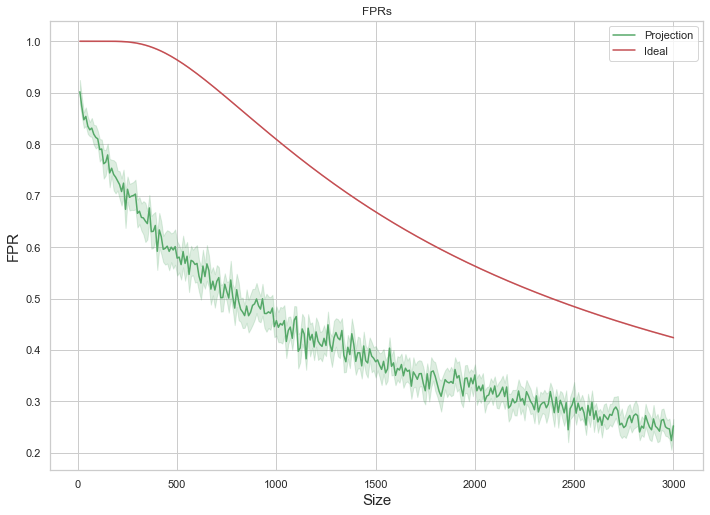

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [21]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [22]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [23]:
print(average_fprs)

[0.9016949152542372, 0.8722457627118645, 0.8472457627118646, 0.8538135593220337, 0.8347457627118644, 0.8277542372881357, 0.8311440677966102, 0.8192796610169492, 0.8131355932203391, 0.8101694915254237, 0.7894067796610169, 0.7904661016949152, 0.761864406779661, 0.7648305084745762, 0.7790254237288137, 0.7440677966101694, 0.7531779661016949, 0.7411016949152541, 0.7358050847457629, 0.7283898305084746, 0.7213983050847459, 0.7078389830508474, 0.7241525423728815, 0.6733050847457627, 0.7122881355932204, 0.6966101694915254, 0.6989406779661019, 0.7002118644067796, 0.7029661016949152, 0.6654661016949153, 0.6697033898305086, 0.6576271186440679, 0.6565677966101694, 0.6504237288135594, 0.6455508474576271, 0.6760593220338983, 0.6298728813559322, 0.6307203389830509, 0.641949152542373, 0.5917372881355931, 0.6332627118644067, 0.6203389830508474, 0.5955508474576272, 0.597457627118644, 0.6016949152542372, 0.5915254237288134, 0.5997881355932205, 0.5942796610169492, 0.6008474576271186, 0.5783898305084746, 0.

In [24]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.0,0.953390,0.901695,0.448403,0.702927
1,20,1.0,0.775424,0.872246,0.397285,0.696358
2,30,1.0,0.877119,0.847246,0.403805,0.694455
3,40,1.0,0.817797,0.853814,0.407437,0.704039
4,50,1.0,0.779661,0.834746,0.502101,0.706029


In [26]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Cardio_rerun_epochs_100.csv')